# Import modules

In [1]:
import sys
import os
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

import datacube
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.storage import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
from digitalearthau.utils import wofs_fuser

#We have to add the plotting tools to the directory list with path.append
sys.path.append('../10_Scripts/')
import DEAPlotting, DEADataHandling

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

%load_ext autoreload

%autoreload 2

# Get stream gauge data 

In [13]:
#load csv file and skip data description lines.
gauge_data = pd.read_csv('/g/data/r78/kd6095/dea-notebooks/Tantangara/Tantangara_water_level.csv',
                error_bad_lines = False, skiprows=9, escapechar='#', 
                         parse_dates=['Timestamp'], #Tells it this column is dates
                         index_col='Value', #sets the coordinate to Value (you don't plot duration curves by time, 
                         #you plot them by value)
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0]))

#organise gauge data into a water-level duration curve
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100

gauge_data = gauge_data.drop(columns='Interpolation Type')
gauge_data = gauge_data.drop(columns='Quality Code')

In [18]:
gauge_data.head()

,Timestamp,rownumber,Exceedence
Value,,,
1205.383,2007-02-09,0,100.000000
1205.394,2007-02-10,1,99.989793
1205.402,2007-02-08,2,99.979586
1205.421,2007-02-07,3,99.969378
1205.433,2007-02-06,4,99.959171


# Convert csv to xarray and make duration curve

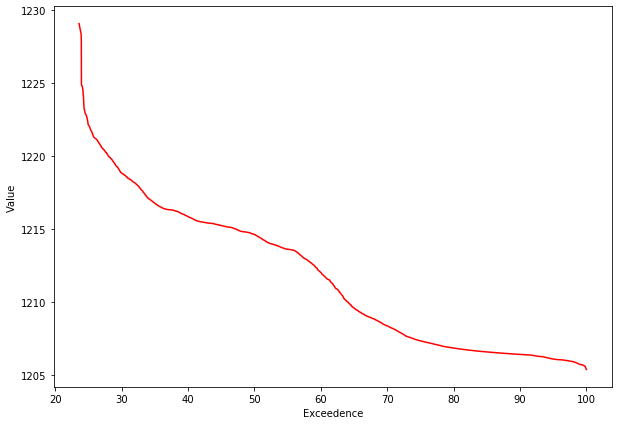

In [19]:
gauge_data_xr = gauge_data.to_xarray()
gauge_data_xr.Exceedence.plot(y='Value', color='red', figsize=(10,7)) #Value must be one of the coordinates because
                                                                      # you set it as index_col. 

# Get WOfS data 

In [ ]:
#I would eventually like to be able to automate the lat lon selection depending on the selected gauge
lat, lon, buffer = -35.75, 148.66, 6500

x, y = geometry.point(lon, lat, CRS('WGS84')).to_crs(CRS('EPSG:3577')).points[0]
query = {'x': (x - buffer, x + buffer),
         'y': (y - buffer, y + buffer),    
         'time': ('2018-01-01', '2019-01-01'),
         'crs': 'EPSG:3577'} 

dc = datacube.Datacube(app='dc-WOfS')
wofs_albers= dc.load(product = 'wofs_albers', **query)

In [ ]:
wofs_albers

# Cloud mask

In [ ]:
ClearTimesteps = []
#Make a for-loop
for ix, timestep in enumerate(wofs_albers.time):
    SingleTime = wofs_albers.water.isel(time=ix)
    IsItCloudy = masking.make_mask(SingleTime, cloud=True)
    CountClouds = IsItCloudy.sum()
    
#Here's the part that measures the percentage of bit flags that mean cloud in the satellite image
    PercentCloudy = CountClouds.values.item()/(len(wofs_albers.x)*len(wofs_albers*y))*100
#And here's the part where we select how much cloud we're willing to accept in our satellite images. try 20. 
    IsItClearEnough = PercentCloudy <= 20
    
#Then we say 'if IsItClearEnough = True, then append it to an index called ClearTimesteps'.
    if IsItClearEnough:
        ClearTimesteps.append(ix)
#redefine wofs_albers so that it only returns useable data (ie clear passes)
wofs_albers = wofs_albers.water.isel(time = ClearTimesteps)

In [ ]:
wofs_albers_time = wofs_albers.time

In [ ]:
wofs_albers_time

# Merge data 